# Nhập thư viện

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, Dense,Activation, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.layers import MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow import keras

Tải dữ liệu

In [ ]:
def loading_the_data(data_dir):
  filepaths=[]
  labels=[]

  folds=os.listdir(data_dir)
  for fold in folds:
    foldpath=os.path.join(data_dir, fold)
    filelist=os.listdir(foldpath)
    for file in filelist:
      fpath=os.path.join(foldpath, file)
      filepaths.append(fpath)
      labels.append(fold)

  Fseries = pd.Series(filepaths, name='filepaths')
  Lseries = pd.Series(labels, name='labels')

  df = pd.concat([Fseries, Lseries], axis=1)

  return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/images'
df = loading_the_data(data_dir)
df

flower_categories = os.listdir(data_dir)
print(f" Flower classes : {flower_categories}")

 Flower classes : ['tulip', 'daisy', 'dandelion', 'sunflower', '.ipynb_checkpoints']


# Trực quan hóa dữ liệu

In [ ]:
classes = []
num_files = []
for category in flower_categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        classes.append(category)
        num_files.append(len(os.listdir(category_path)))
print(f"Flower classes: {classes}")
print(f"Number of files in each class: {num_files}")

Flower classes: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
Number of files in each class: [1052, 764, 733, 984, 784]


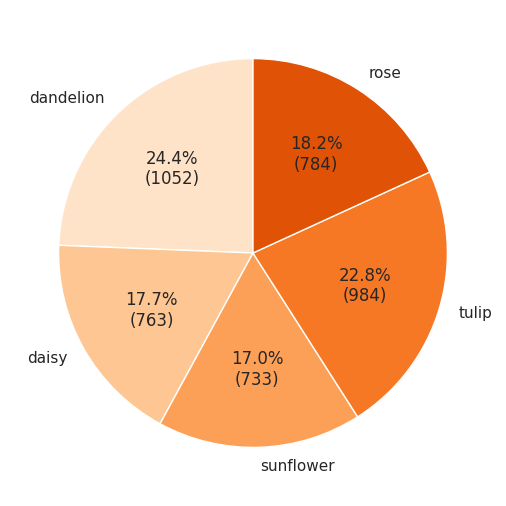

In [ ]:
colors = sns.color_palette("Oranges")
def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
plt.figure(figsize=(6,6))
plt.pie(num_files, labels=classes, autopct=lambda pct: func(pct, num_files),
        startangle=90, colors=colors);

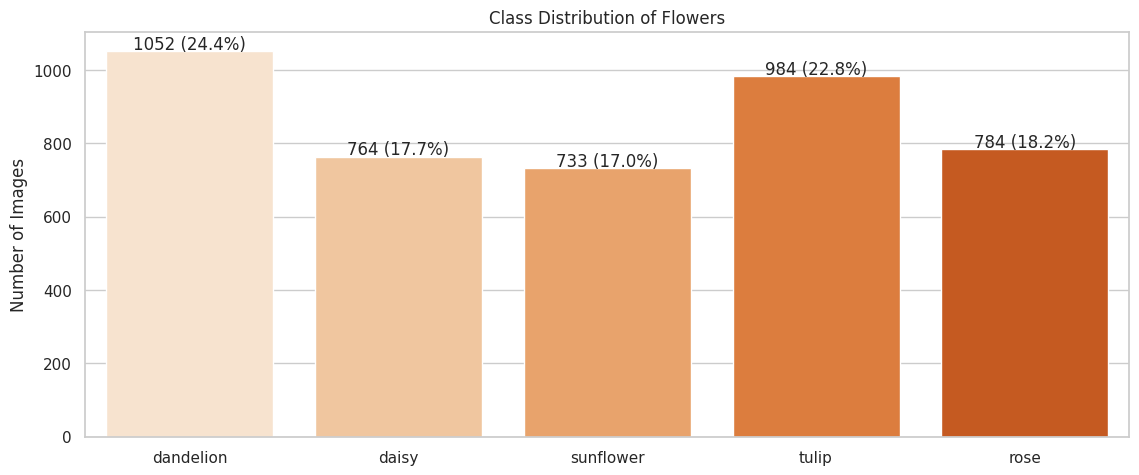

In [ ]:
def plot_class_distribution(classes, num_files):
    total = sum(num_files)
    plt.figure(figsize=(12, 5))
    sns.barplot(x=classes, y=num_files, palette=colors)
    for i in range(len(num_files)):
        count = num_files[i]
        pct = count / total * 100
        plt.text(i, count + 5, f'{count} ({pct:.1f}%)', ha='center')
    plt.title('Class Distribution of Flowers')
    plt.ylabel('Number of Images')
    plt.show()
plot_class_distribution(classes, num_files)

Hiển thị ngẫu nhiên ảnh của mỗi lớp hoa

In [ ]:
import random
import matplotlib.image as mpimg
def display_random_images(category, num_images=5):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        selected_images = random.sample(images, num_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, image_name in enumerate(selected_images):
            image_path = os.path.join(category_path, image_name)
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Shape: {img.shape}")
        plt.tight_layout()
        plt.show()

In [ ]:
classes

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

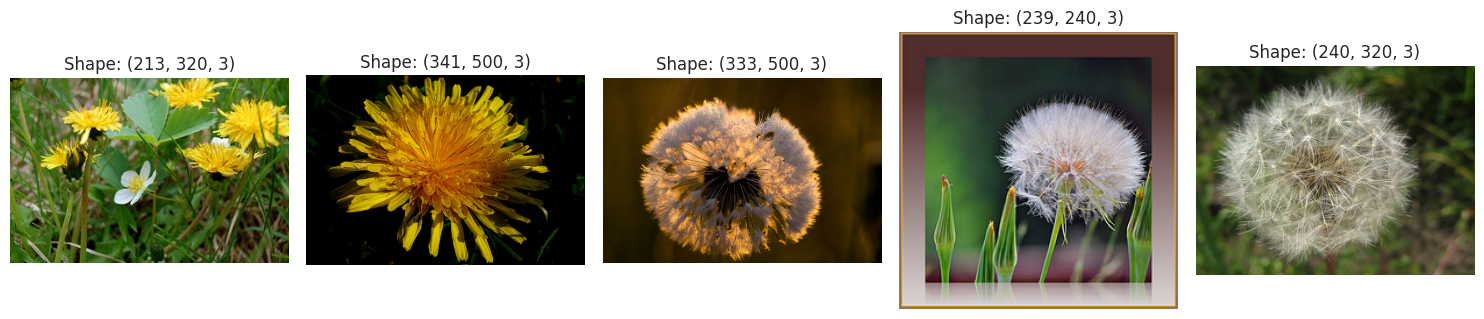

In [ ]:
display_random_images('dandelion')

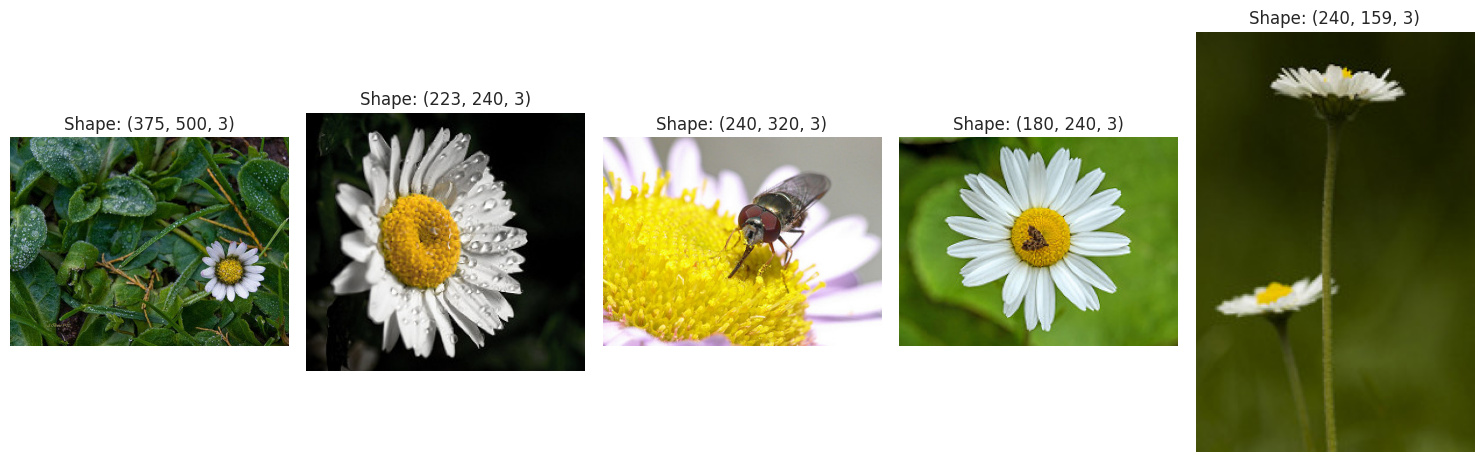

In [ ]:
display_random_images('daisy')

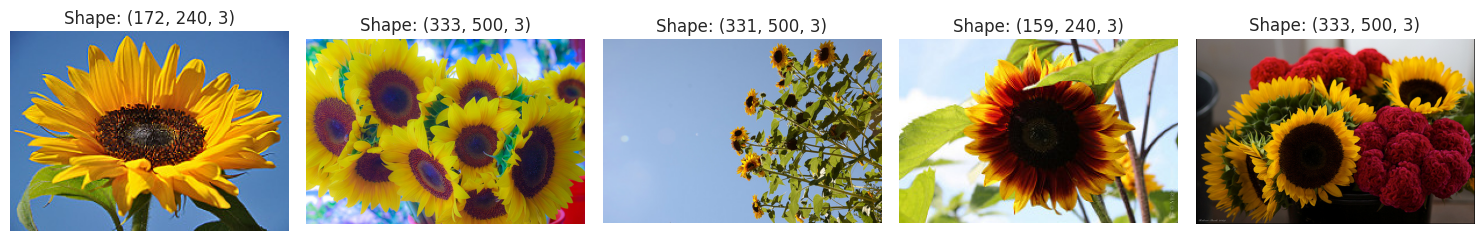

In [ ]:
display_random_images('sunflower')

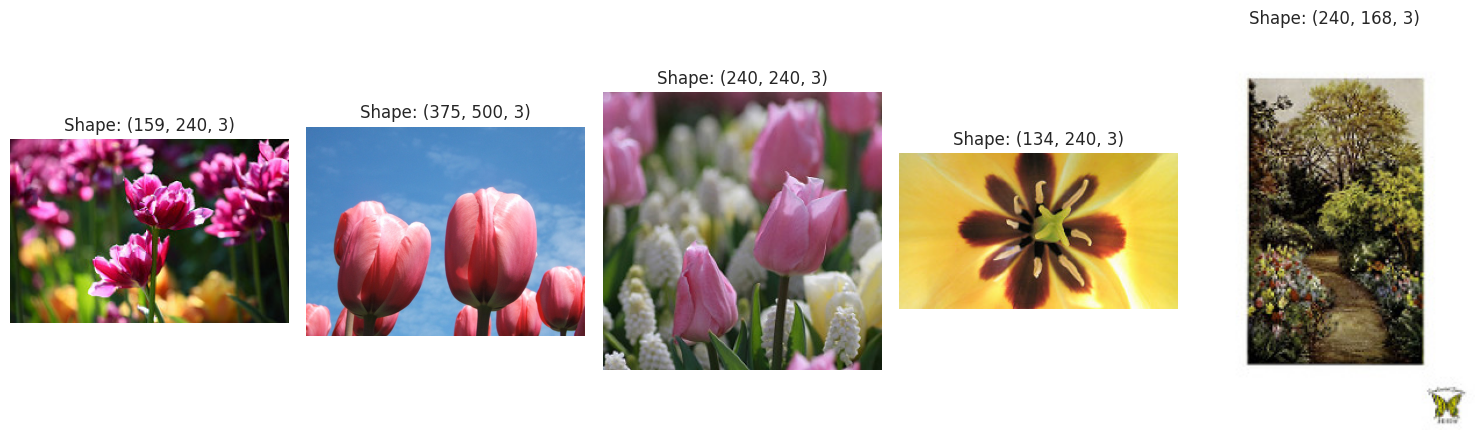

In [ ]:
display_random_images('tulip')

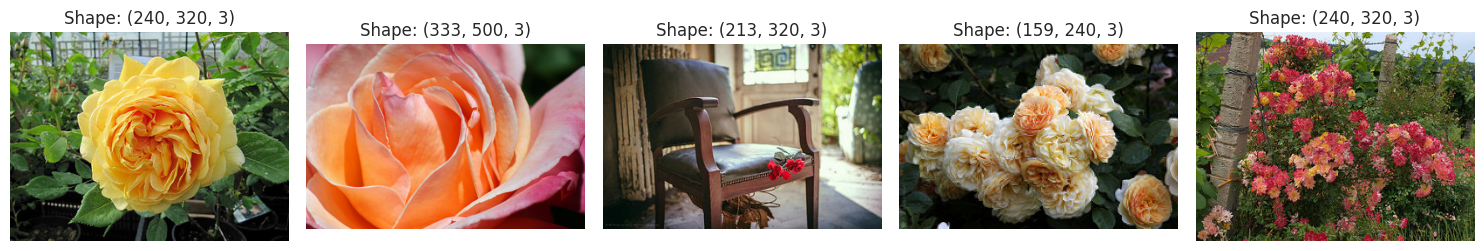

In [ ]:
display_random_images('rose')

Kiểm tra giá trị pixels

In [ ]:
for category in flower_categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        if len(images) > 17:
            image_name = images[17]
            image_path = os.path.join(category_path, image_name)
            img = mpimg.imread(image_path)
            print(f'{category} index 17 max: {img.max()}')
            print(f'{category} index 17 min: {img.min()}')
        else:
            print(f"{category} does not have an image at index 17.")

dandelion index 17 max: 255
dandelion index 17 min: 0
daisy index 17 max: 255
daisy index 17 min: 0
sunflower index 17 max: 255
sunflower index 17 min: 0
tulip index 17 max: 255
tulip index 17 min: 0
rose index 17 max: 255
rose index 17 min: 0


Hình dạng trung bình của ảnh

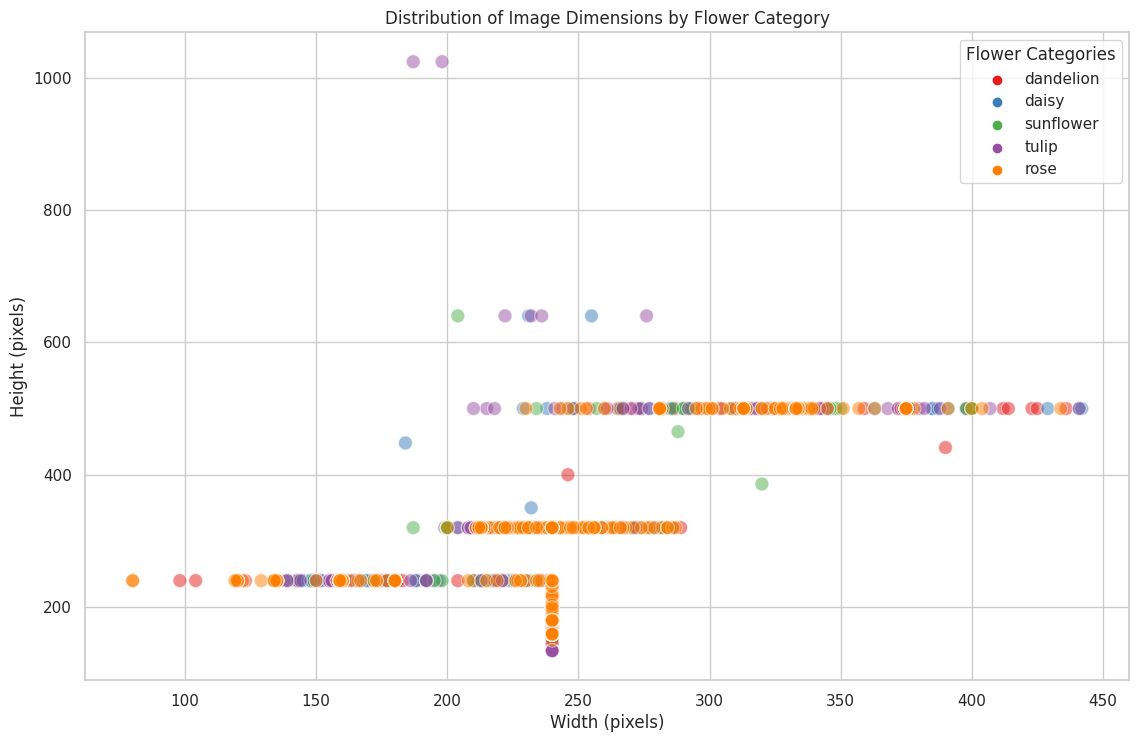

Mean height (x): 253.07
Mean width (y): 338.38


In [ ]:
x, y, categories = [], [], []

for category in flower_categories:
    category_path = os.path.join(data_dir, category)
    files = os.listdir(category_path)
    for image in files:
        try:
            img = mpimg.imread(os.path.join(category_path, image))
            d1, d2, _ = img.shape
            x.append(d1)
            y.append(d2)
            categories.append(category)
        except OSError as e:
            print(f"Error processing {image}: {e}")
            continue
plt.figure(figsize=(12, 8))
sns.scatterplot(x=x, y=y, hue=categories, palette='Set1', alpha=0.5, s=100)
plt.title('Distribution of Image Dimensions by Flower Category')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend(title='Flower Categories')
plt.grid(True)
plt.show()

print(f'Mean height (x): {np.mean(x):.2f}')
print(f'Mean width (y): {np.mean(y):.2f}')

# Tiền xử lý dữ liệu

In [ ]:
seed=42
image_shape = (224, 224, 3)
epochs = 50
target_size=(224, 224)
batch_size = 32
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0)

In [ ]:
# Chia dữ liệu
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
train_aug_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = train_aug_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=True
)

val_gen = image_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=False)

test_gen = image_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="categorical",
    shuffle=False)

Found 3453 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.


In [ ]:
train_size = len(train_gen)
val_size = len(val_gen)
test_size = len(test_gen)

#Tính toán kích thước của tập dữ liệu
total_size = train_size + val_size + test_size
train_ratio = train_size / total_size
val_ratio = val_size / total_size
test_ratio = test_size / total_size

# Chuẩn bị dữ liệu cho biểu đồ
data_sets = ['Training + Validation', 'Testing']
train_val_values = [train_ratio, 0]
val_values = [val_ratio, 0]
test_values = [0, test_ratio]

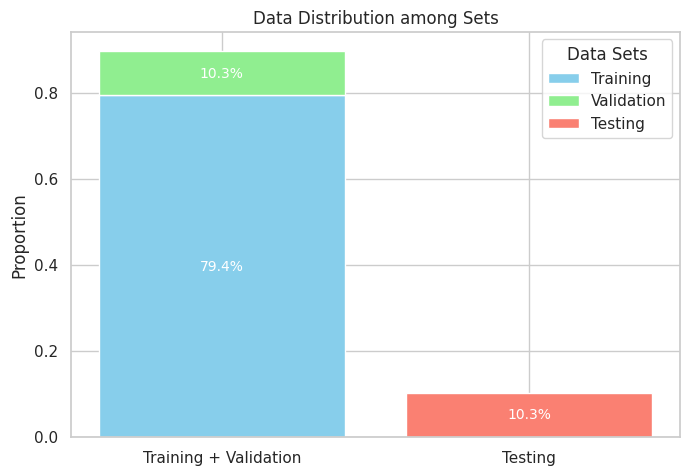

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = ['skyblue', 'lightgreen', 'salmon']
ax.bar(data_sets, train_val_values, color=colors[0], label='Training')
ax.bar(data_sets, val_values, bottom=train_val_values, color=colors[1], label='Validation')
ax.bar(data_sets, test_values, color=colors[2], label='Testing')
ax.set_ylabel('Proportion')
ax.set_title('Data Distribution among Sets')
ax.legend(title='Data Sets', loc='upper right')
ax.text(0, train_ratio/2, f'{train_ratio:.1%}', ha='center', va='center', color='white', fontsize=10)
ax.text(0, train_ratio + val_ratio/2, f'{val_ratio:.1%}', ha='center', va='center', color='white', fontsize=10)
ax.text(1, test_ratio/2, f'{test_ratio:.1%}', ha='center', va='center', color='white', fontsize=10)

plt.show()

In [ ]:
#đánh giá mô hình
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose=1)
    valid_score = model.evaluate(val_gen, verbose=1)
    test_score = model.evaluate(test_gen, verbose=1)

    print('-' * 20)
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print('-' * 20)

In [ ]:
#Hiển thị hiệu suất của mô hình
def model_performance(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(20, 7))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_acc, 'blue', marker='o',label='Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', marker='o',label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'blue',marker='o', label='Training loss')
    plt.plot(epochs, val_loss, 'orange', marker='o',label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#Ma trận nhầm lẫn
from itertools import product

def plot_confusion_matrix(test_gen, y_pred):
    classes = list(test_gen.class_indices.keys())
    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Oranges')
    plt.title('Confusion Matrix', fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    thresh = cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha='center', fontsize=10,
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# CNN model

In [ ]:
CNN = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=image_shape),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    GlobalMaxPooling2D(),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(5, activation='softmax')
])

In [ ]:
CNN.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [ ]:
CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,149 (1.55 MB)

 Trainable params: 405,253 (1.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
#Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=3,
                                 min_lr=0.00001)

#EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

In [ ]:
history = CNN.fit(
                train_gen,
                validation_data=val_gen,
                epochs=epochs,
                callbacks=[early_stop, lr_scheduler])

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 44s 379ms/step - accuracy: 0.3656 - loss: 2.4871 - val_accuracy: 0.3519 - val_loss: 1.8338 - learning_rate: 5.0000e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - accuracy: 0.5043 - loss: 1.4381 - val_accuracy: 0.3403 - val_loss: 1.8994 - learning_rate: 5.0000e-04
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.5791 - loss: 1.2869 - val_accuracy: 0.4375 - val_loss: 1.6952 - learning_rate: 5.0000e-04
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 359ms/step - accuracy: 0.5826 - loss: 1.2606 - val_accuracy: 0.5301 - val_loss: 1.3836 - learning_rate: 5.0000e-04
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 355ms/step - accuracy: 0.6247 - loss: 1.1617 - val_accuracy: 0.6505 - val_loss: 1.1752 - learning_rate: 5.0000e-04
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 361ms/step - accuracy: 0.6542 - loss: 1.1172 - val_accuracy: 0.6343 - val_loss: 1.1248 - learning_rate: 5.0000e-04
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 35

đánh giá mô hình

In [ ]:
train_score = CNN.evaluate(train_gen, verbose=1)
valid_score = CNN.evaluate(val_gen, verbose=1)
test_score = CNN.evaluate(test_gen, verbose=1)

print('-' * 20)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)

108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 373ms/step - accuracy: 0.8089 - loss: 0.6751
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7598 - loss: 0.7720
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8164 - loss: 0.6309
--------------------
Train Loss:  0.6540321111679077
Train Accuracy:  0.8163915276527405
--------------------
Validation Loss:  0.7642589807510376
Validation Accuracy:  0.7638888955116272
--------------------
Test Loss:  0.6522378325462341
Test Accuracy:  0.8125
--------------------


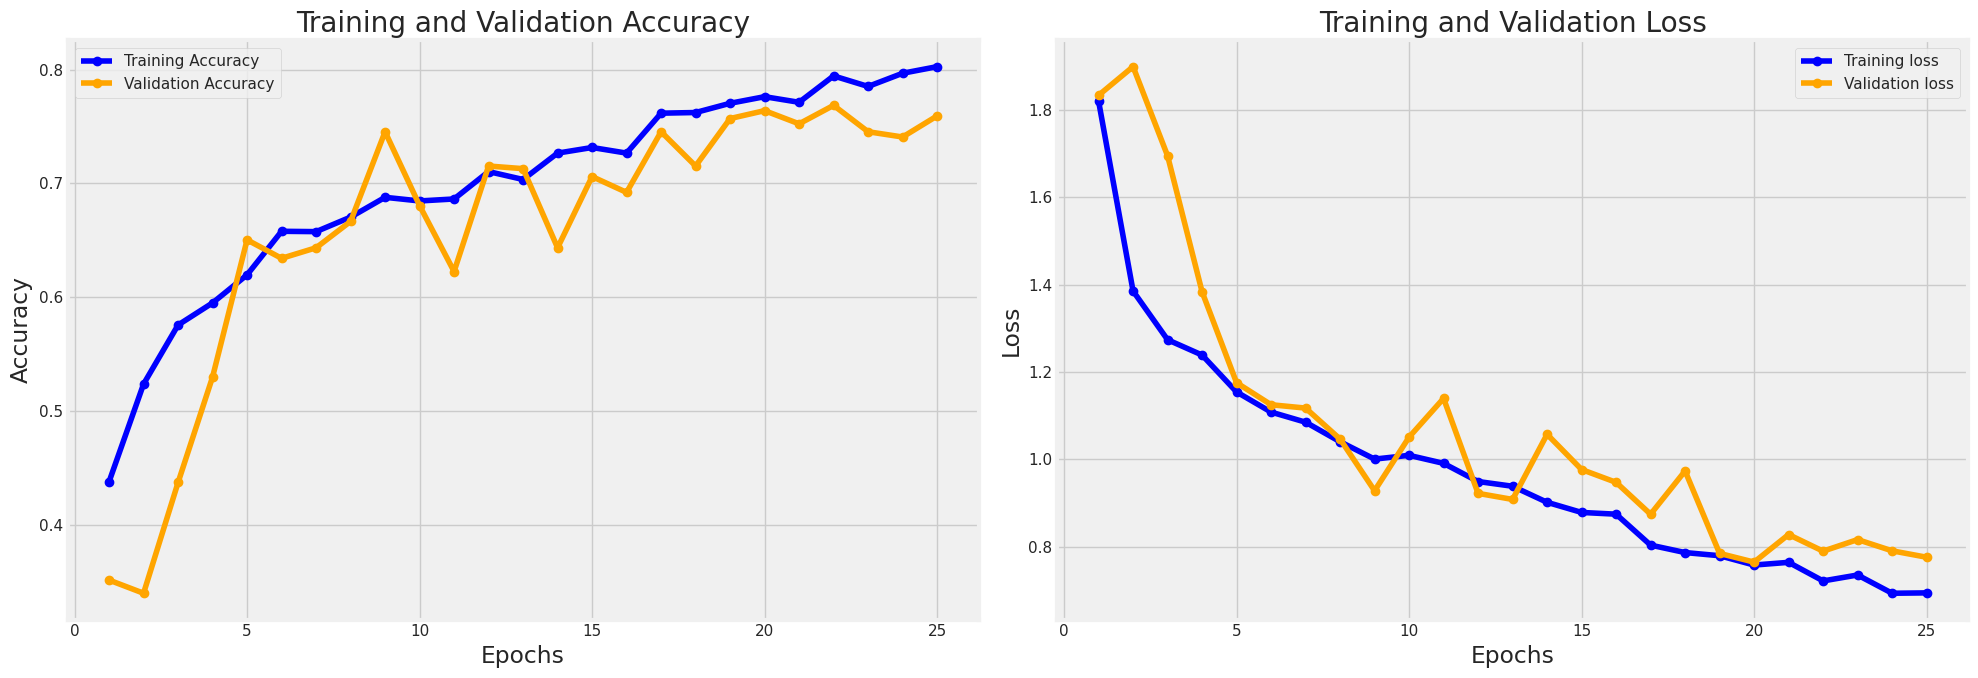

In [ ]:
model_performance(history)

Dự đoán

In [ ]:
preds = CNN.predict(test_gen)
predictions = np.argmax(preds, axis=1)

# đánh giá các chỉ số hiệu suất
print(classification_report(test_gen.classes, predictions))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        82
           1       0.88      0.83      0.85       104
           2       0.65      0.77      0.71        71
           3       0.82      0.90      0.86        83
           4       0.85      0.73      0.78        92

    accuracy                           0.81       432
   macro avg       0.81      0.81      0.81       432
weighted avg       0.82      0.81      0.81       432



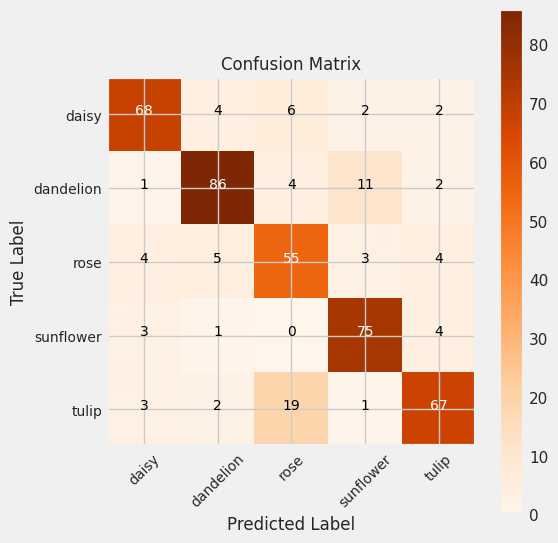

In [ ]:
plot_confusion_matrix(test_gen, predictions)

# VGG16

VGG16 base model


In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True)

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 Pre-trained Model
pretrained_model = VGG16(
    input_shape=image_shape,
    include_top=False,
    pooling='avg',
    weights="imagenet")

# Freeze the pre-trained model initially
pretrained_model.trainable = False

# Input layer
inputs = keras.Input(shape=image_shape)
x = pretrained_model(inputs)
outputs = keras.layers.Dense(5, activation='softmax')(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Create the model using Functional API
VGG16_base = keras.Model(inputs, outputs)

In [ ]:
VGG16_base.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'])

VGG16_base.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Save the best model's weights using ModelCheckpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_vgg16_weights.weights.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True)

In [ ]:
# Train the model with frozen layers
history = VGG16_base.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, checkpoint_cb])

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 57s 435ms/step - accuracy: 0.2056 - loss: 1.7310 - val_accuracy: 0.2176 - val_loss: 1.6196
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 360ms/step - accuracy: 0.2314 - loss: 1.5981 - val_accuracy: 0.2940 - val_loss: 1.5521
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - accuracy: 0.3346 - loss: 1.5373 - val_accuracy: 0.4074 - val_loss: 1.5047
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 358ms/step - accuracy: 0.4251 - loss: 1.4983 - val_accuracy: 0.4514 - val_loss: 1.4639
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 365ms/step - accuracy: 0.4518 - loss: 1.4599 - val_accuracy: 0.5000 - val_loss: 1.4218
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 361ms/step - accuracy: 0.5225 - loss: 1.4155 - val_accuracy: 0.5301 - val_loss: 1.3850
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 363ms/step - accuracy: 0.5215 - loss: 1.3883 - val_accuracy: 0.5509 - val_loss: 1.3527
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 363ms/step - accuracy: 0.5501 - loss: 1

In [ ]:
test_loss, test_accuracy = VGG16_base.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6549 - loss: 1.0447
Test Loss: 1.0403339862823486
Test Accuracy: 0.6712962985038757


Fine tuning

In [ ]:
# Unfreeze the VGG16 model layers for fine-tuning
pretrained_model.trainable = True

VGG16_model = keras.Model(inputs, outputs)
# Re-compile the model with a lower learning rate for fine-tuning
VGG16_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy'])

VGG16_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 14,717,253 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fine-tune the model (with all layers trainable)
history_vgg = VGG16_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, checkpoint_cb])

Epoch 1/50


I0000 00:00:1728407517.754405     155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads



 67/108 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.7106 - loss: 0.8130

I0000 00:00:1728407550.823017     154 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads



108/108 ━━━━━━━━━━━━━━━━━━━━ 65s 460ms/step - accuracy: 0.7321 - loss: 0.7458 - val_accuracy: 0.8796 - val_loss: 0.3972
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 44s 380ms/step - accuracy: 0.8522 - loss: 0.4122 - val_accuracy: 0.8773 - val_loss: 0.3682
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 44s 380ms/step - accuracy: 0.8906 - loss: 0.3033 - val_accuracy: 0.8958 - val_loss: 0.2940
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 44s 382ms/step - accuracy: 0.8991 - loss: 0.2691 - val_accuracy: 0.9167 - val_loss: 0.2652
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 366ms/step - accuracy: 0.9257 - loss: 0.2024 - val_accuracy: 0.8889 - val_loss: 0.3115
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9270 - loss: 0.1981 - val_accuracy: 0.8843 - val_loss: 0.3099
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9403 - loss: 0.1710 - val_accuracy: 0.9074 - val_loss: 0.3022


Đánh giá mô hình

In [ ]:
train_score = VGG16_model.evaluate(train_gen, verbose=1)
valid_score = VGG16_model.evaluate(val_gen, verbose=1)
test_score = VGG16_model.evaluate(test_gen, verbose=1)

print('-' * 20)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print('-' * 20)

108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 366ms/step - accuracy: 0.9425 - loss: 0.1719
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9032 - loss: 0.2680
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9504 - loss: 0.1730
--------------------
Train Loss:  0.17935556173324585
Train Accuracy:  0.9383144974708557
--------------------
Validation Loss:  0.2651812732219696
Validation Accuracy:  0.9166666865348816
--------------------
Test Loss:  0.2291060835123062
Test Accuracy:  0.9305555820465088
--------------------


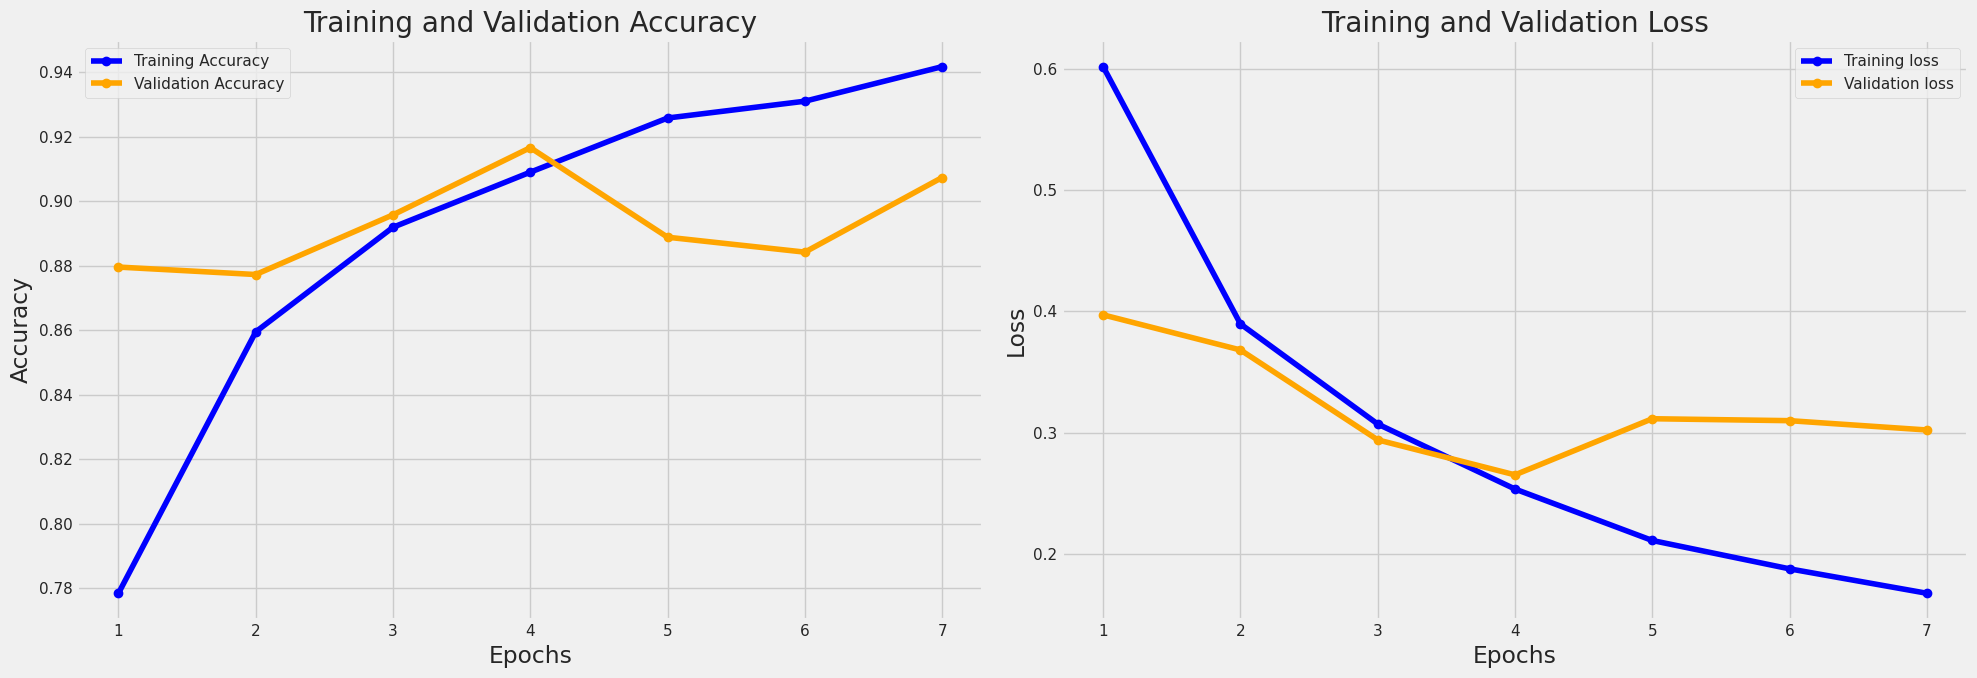

In [ ]:
model_performance(history_vgg)

Dự đoán

In [ ]:
preds = VGG16_model.predict(test_gen)
predictions = np.argmax(preds, axis=1)

# đánh giá các chỉ số hiệu suất
print(classification_report(test_gen.classes, predictions))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        82
           1       0.95      0.96      0.96       104
           2       0.80      0.94      0.86        71
           3       0.99      0.95      0.97        83
           4       0.96      0.85      0.90        92

    accuracy                           0.93       432
   macro avg       0.93      0.93      0.93       432
weighted avg       0.94      0.93      0.93       432



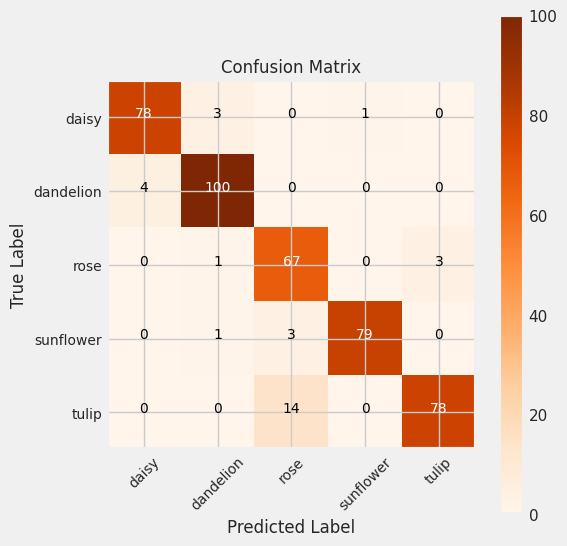

In [ ]:
plot_confusion_matrix(test_gen, predictions)

# Chọn mô hình tốt nhất

In [16]:
test_results = [
    {'Model': 'CNN', 'Train_Accuracy': 0.8, 'Val_Accuracy': 0.87, 'Test_Accuracy': 0.81},
    {'Model': 'VGG16', 'Train_Accuracy': 0.93, 'Val_Accuracy': 0.91, 'Test_Accuracy': 0.93},
     ]
results_df = pd.DataFrame(test_results)

In [17]:
# Sắp xếp theo Accuracy và Sai số phân loại
sorted_results = results_df.sort_values(by=['Train_Accuracy', 'Val_Accuracy'], ascending=[False, False])

# hiển thị kết quả sau khi sắp xếp
sorted_results_reset = sorted_results.reset_index(drop=True)
print(sorted_results_reset)

   Model  Train_Accuracy  Val_Accuracy  Test_Accuracy
0  VGG16            0.93          0.91           0.93
1    CNN            0.80          0.87           0.81


In [ ]:
VGG16_model.save('VGG16_model.keras')

In [ ]:
model = load_model('/content/VGG16_model.keras')